This file performs the analysis on the classification accuracies of the support vector machine, trained and tested using cross-validation. It performs different analyses and makes a few plots. 

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from textwrap import wrap

import statsmodels.api as sm
from statsmodels.formula.api import ols 

In [20]:
one_rest = True # Whether to count REST1 as the same task as REST2
## Plotting parameters
label_fontsize = 20
tick_fontsize = 16
wrapsize = 25

In [21]:
def logit(p):
    """
    Logit function 
    PARAMS:
    p : probability 
    """
    return np.log(p/(1-p))

def invlogit(x):
    """
    Inverse logit function (a.k.a. logistic function) 
    PARAMS:
    x : logit-transformed probability
    """
    return 1/(1+np.exp(-x))

def arcsin_sqrt(p):
    """
    Arcsin square-root transformation
    PARAMS:
    p : probability
    """
    return np.arcsin(np.sqrt(p))

In [22]:
folder = os.path.join(os.getcwd(),'SVM')
correlation_folder = os.path.join(folder, 'correlations')

In [23]:
one_rest_txt = '_one_rest' if one_rest else ''
if one_rest:
    folder = os.path.join(folder, "one_rest")

In [24]:
edge_types = ['bin', 'con']
geometries = ['euc', 'hyp']
## Pretty plot variable names
pplot = {'bin':'Binary', 'con':'Continuous','euc':'Euclidean', 'hyp':'Hyperbolic'}
pretty_title = {'bin_euc':'Binary Euclidean', 'bin_hyp':'Binary hyperbolic', 'con_euc':'Continuous Euclidean', 'con_hyp':'Continuous hyperbolic'}

n_folds = 10
n_tests = 90
tasks = ['REST1', 'REST2','EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']
or_tasks = ['REST','EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']
n_tasks = len(tasks)

In [25]:
edge_type = []
geometry = []
correct = []
mistakes = {}
for i, et in enumerate(edge_types):
    for j, geo in enumerate(geometries):
        ## Load the cross-validation accuracies, and save the accuracies, as well as the mistakes
        filename = os.path.join(folder, f"cv_accuracy_{et}_{geo}{one_rest_txt}.pkl")
        with open(filename, 'rb') as f:
            loaded_data = pickle.load(f)

        acc = list(np.mean(np.array(loaded_data[:,:,0]==loaded_data[:,:,1]), axis=1))
        mistakes[f"{et}_{geo}"] = loaded_data[np.where(loaded_data[:,:,0]!=loaded_data[:,:,1])]
        edge_type = edge_type + [pplot[et]]*n_folds
        geometry = geometry + [pplot[geo]]*n_folds
        correct = correct + acc

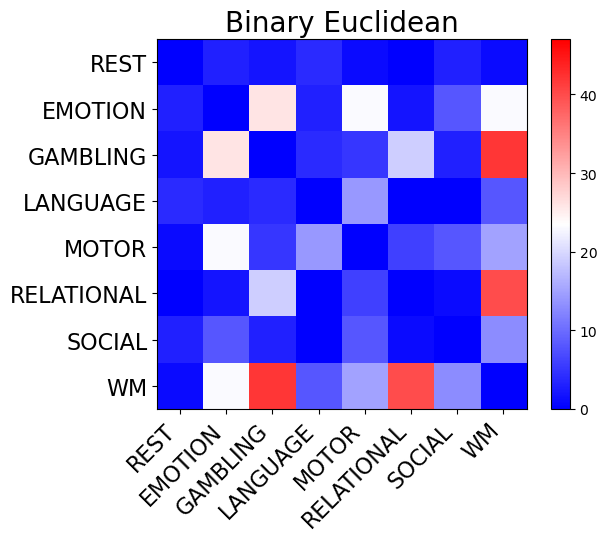

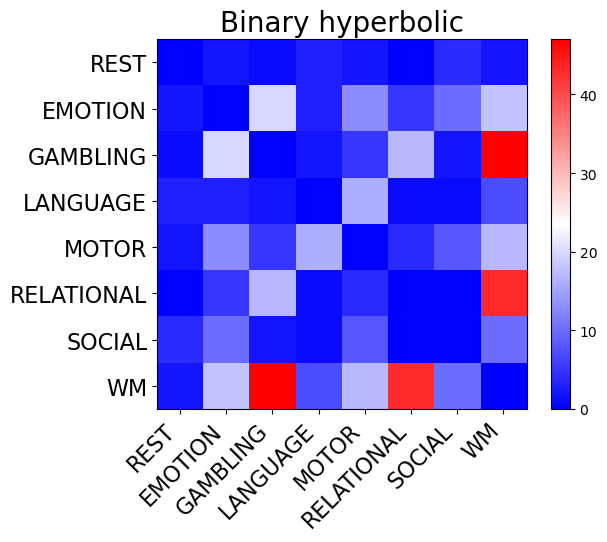

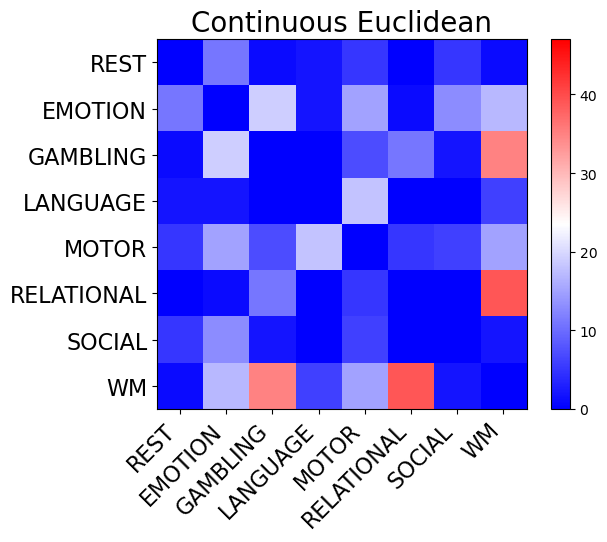

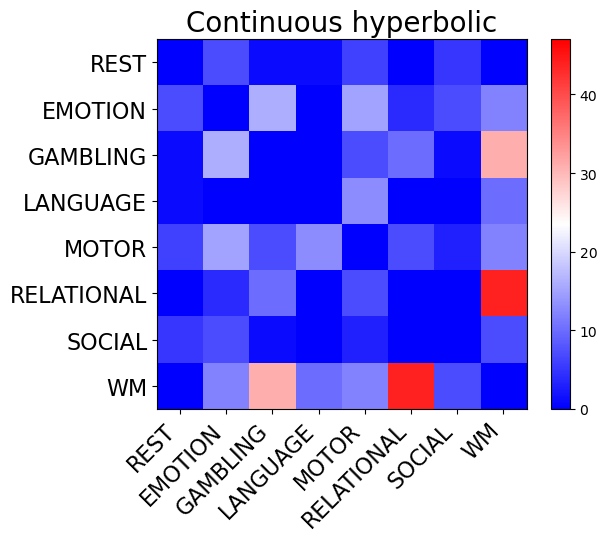

In [26]:
lab = or_tasks if one_rest else tasks
## Count the mistakes
mistake_mats = []
for model, mist in mistakes.items():
    mistake_mat = np.zeros((n_tasks,n_tasks))
    for m in mist:
        mistake_mat[m[0],m[1]] += 1
        mistake_mat[m[1],m[0]] += 1
    if one_rest: # Note that these would would be all zeros, since REST2 is removed from the data entirely
        mistake_mat = np.delete(mistake_mat, 1, 0)
        mistake_mat = np.delete(mistake_mat, 1, 1)
    mistake_mats.append(mistake_mat)

## Ensures the coloring of the bars is equivalent between 
max_mistakes = np.max([np.max(mistake_mat) for mistake_mat in mistake_mats])

## Plot the mistakes
for mi, model in enumerate(mistakes.keys()):
    mistake_mat = mistake_mats[mi]
    plt.figure()
    plt.imshow(mistake_mat, cmap='bwr', vmax=max_mistakes)
    plt.colorbar()
    plt.xticks(np.arange(len(lab)), labels=lab, rotation=45, ha='right', fontsize=tick_fontsize)
    plt.yticks(np.arange(len(lab)), labels=lab, fontsize=tick_fontsize)
    plt.title(pretty_title[model], {'fontsize': label_fontsize})
    savename = os.path.join(folder, f'classification_mistakes_{model}{one_rest_txt}.png')
    plt.savefig(savename, bbox_inches='tight')

In [27]:
## Construct the full dataframe, including the logit and arcsin square-root transformed accuracies.
df = pd.DataFrame({'edge_type':edge_type, 'geometry':geometry, 'correct':correct})
df['logit_correct'] = logit(df['correct'])
df['arcsinsqrt_correct'] = arcsin_sqrt(df['correct'])
print(f"Min = {np.min(df['correct'])}, Max = {np.max(df['correct'])}")
df.head()

Min = 0.6333333333333333, Max = 0.8


,edge_type,geometry,correct,logit_correct,arcsinsqrt_correct
0,Binary,Euclidean,0.755556,1.128465,1.053637
1,Binary,Euclidean,0.666667,0.693147,0.955317
2,Binary,Euclidean,0.722222,0.955511,1.015675
3,Binary,Euclidean,0.700000,0.847298,0.991157
4,Binary,Euclidean,0.688889,0.794930,0.979096


### Load correlation SVM accuracy 
Comparing the LSMs' results to the SVM accuracies scored on the correlation data (i.e. not embedded) shows whether LSMs perform useful feature extraction. 

In [28]:
filename = os.path.join(correlation_folder, f"cv_accuracy_avg_correlations{one_rest_txt}.pkl")
with open(filename, 'rb') as f:
    corr_data = pickle.load(f)

## Calculate accuracies 
corr_acc = list(np.mean(np.array(corr_data[:,:,0]==corr_data[:,:,1]), axis=1))
corr_mistakes = corr_data[np.where(corr_data[:,:,0]!=corr_data[:,:,1])]

## Count the mistakes
corr_mistake_mat = np.zeros((n_tasks,n_tasks))
for m in corr_mistakes:
    corr_mistake_mat[m[0],m[1]] += 1
    corr_mistake_mat[m[1],m[0]] += 1
if one_rest: 
    corr_mistake_mat = np.delete(corr_mistake_mat, 1, 0)
    corr_mistake_mat = np.delete(corr_mistake_mat, 1, 1)

In [29]:
## Construct the same dataframe for the model-free accuracies.
corr_df = pd.DataFrame({'correct':corr_acc})
corr_df['logit_correct'] = logit(corr_df['correct'])
corr_df['arcsinsqrt_correct'] = arcsin_sqrt(corr_df['correct'])
corr_df.tail()

,correct,logit_correct,arcsinsqrt_correct
5,0.877778,1.971553,1.213649
6,0.888889,2.079442,1.230959
7,0.855556,1.778856,1.180937
8,0.844444,1.691676,1.165376
9,0.866667,1.871802,1.197004


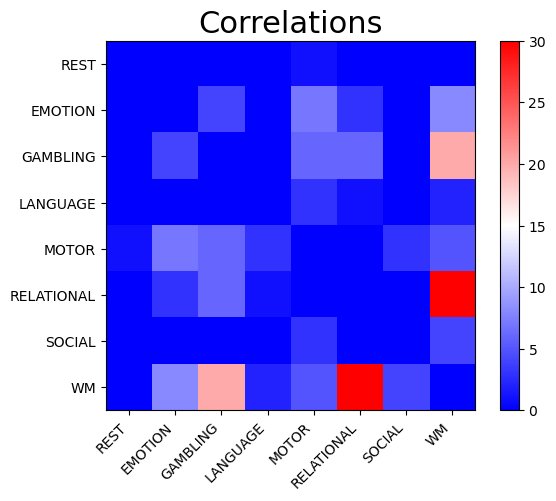

In [30]:
lab = or_tasks if one_rest else tasks

plt.figure()
plt.imshow(corr_mistake_mat, cmap='bwr')
plt.colorbar()
plt.xticks(np.arange(len(lab)), labels=lab, rotation=45, ha='right')
plt.yticks(np.arange(len(lab)), labels=lab)
plt.title('Correlations', {'fontsize': 22})
savename = os.path.join(folder, f'corr_classification_mistakes{one_rest_txt}.png')
plt.savefig(savename, bbox_inches='tight')

In [31]:
## Construct a dataframe which combines the modeled and model-free accuracies 
comb_df = pd.concat([corr_df, df], ignore_index = True)
comb_df['model'] =  np.logical_not(comb_df['edge_type'].isna())
comb_df.tail()

,correct,logit_correct,arcsinsqrt_correct,edge_type,geometry,model
45,0.711111,0.900787,1.003346,Continuous,Hyperbolic,True
46,0.777778,1.252763,1.079914,Continuous,Hyperbolic,True
47,0.744444,1.069198,1.040806,Continuous,Hyperbolic,True
48,0.755556,1.128465,1.053637,Continuous,Hyperbolic,True
49,0.733333,1.011601,1.028157,Continuous,Hyperbolic,True


### Difference of differences
To investigate the interaction between edge type and latent space geometry, we look at the differences between the two geometries within each edge type, and see if those distributions are different.

C:\Users\Pleun\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.


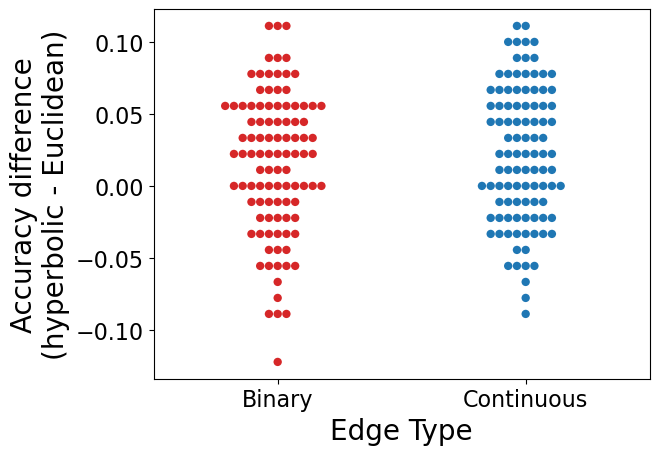

In [32]:
## Extract accuracies
bin_difference_dist = np.zeros(n_folds**2)
con_difference_dist = np.zeros(n_folds**2)
bin_euc_scores = np.array(df['correct'][(df['edge_type']=='Binary') & (df['geometry']=='Euclidean')])
bin_hyp_scores = np.array(df['correct'][(df['edge_type']=='Binary') & (df['geometry']=='Hyperbolic')])
con_euc_scores = np.array(df['correct'][(df['edge_type']=='Continuous') & (df['geometry']=='Euclidean')])
con_hyp_scores = np.array(df['correct'][(df['edge_type']=='Continuous') & (df['geometry']=='Hyperbolic')])

## Construct within-edge type difference distributions
for i in range(n_folds):
    beg = i*n_folds
    end = (i+1)*n_folds
    bin_difference_dist[beg:end] = bin_hyp_scores - np.roll(bin_euc_scores, i)
    con_difference_dist[beg:end] = con_hyp_scores - np.roll(con_euc_scores, i)

## Create a pandas dataframe to be used by the seaborn swarmplot
ets = np.repeat(['Binary', 'Continuous'],n_folds**2)
diffs = np.hstack([bin_difference_dist, con_difference_dist])
diff_df = pd.DataFrame({'Edge type':ets, 'Difference':diffs})

## Plot the within-edge type difference distributions
colors = ['tab:red', 'tab:blue', 'tab:green']
plt.figure()
ax = sns.swarmplot(y='Difference', 
                   x='Edge type', 
                   hue='Edge type',
                   data=diff_df,
                   s=6,
                   palette=colors,
                   )
plt.xlabel('Edge Type', fontsize=label_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.ylabel('\n'.join(wrap('Accuracy difference (hyperbolic - Euclidean)', wrapsize)), fontsize=label_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.gca().get_legend().remove()
savename = os.path.join(folder, f'differences{one_rest_txt}.png')
plt.savefig(savename, bbox_inches='tight')
plt.show()

## Alternative plotting, used in the original thesis, but less informative. Compares two histograms.
# plt.figure()
# plt.hist(bin_difference_dist, n_folds, density=True, color='tab:blue', alpha=0.8)
# plt.hist(con_difference_dist, n_folds, density=True, color='tab:red',  alpha=0.8)
# plt.xticks(fontsize=tick_fontsize)
# plt.xlabel('Difference', fontsize=label_fontsize)
# plt.yticks(fontsize=tick_fontsize)
# plt.ylabel('Density', fontsize=label_fontsize)
# plt.legend(labels,  fontsize=tick_fontsize, bbox_to_anchor= (1.0,1.0) ) #(0.75, 1.4))
# savename = os.path.join(folder, f'differences{one_rest_txt}.png')
# plt.savefig(savename, bbox_inches='tight')
# plt.show()

In [33]:
## Perform an analysis of variance on the two difference distributions
ets = n_folds**2*['Binary'] + n_folds**2*['Continuous']
df_diff = pd.DataFrame({'edge_type':ets, 'difference':np.hstack([bin_difference_dist, con_difference_dist])})
model = ols('difference ~ C(edge_type)', data=df_diff).fit()
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(edge_type),1.0,0.001543,0.001543,0.667656,0.414852
Residual,198.0,0.457654,0.002311,NaN,NaN


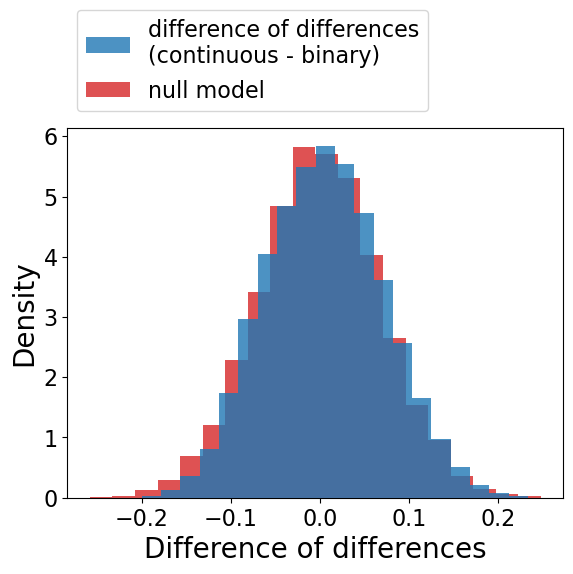

In [34]:
## Alternative plot, using the difference of differences distribution versus a null-distribution
n_dodbins = 100

## Construct the difference of differences distribution
diff_of_diff_dist = np.zeros(n_folds**4)

for i in range(n_folds**2):
    beg = i*n_folds**2
    end = (i+1)*n_folds**2
    diff_of_diff_dist[beg:end] = con_difference_dist - np.roll(bin_difference_dist, i)

## Create null-distribution
std = np.std(diff_of_diff_dist)
null_dist = np.random.normal(scale=std, size=n_folds**4)

## Plot the two distributions
plt.figure()
plt.hist(diff_of_diff_dist, 2*n_folds, density=True, color='tab:blue', alpha=0.8, zorder=3)
plt.hist(null_dist, 2*n_folds, density=True, color='tab:red', alpha=0.8)
_, ymax = plt.ylim()
_labels = ['difference of differences (continuous - binary)', 'null model']
labels = [ '\n'.join(wrap(l, wrapsize)) for l in _labels]
plt.xticks(fontsize=tick_fontsize)
plt.xlabel('Difference of differences', fontsize=label_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.ylabel('Density', fontsize=label_fontsize)
plt.legend(labels, fontsize=tick_fontsize, bbox_to_anchor=(0.75, 1.35))
savename = os.path.join(folder, f'difference_of_differences{one_rest_txt}.png')
plt.savefig(savename, bbox_inches='tight')
plt.show()

In [35]:
## Perform an analysis of variance on the difference of differences distribution
df_dod = pd.DataFrame({'model':n_folds**4*['difference of difference']+n_folds**4*['null'], 
                        'value':np.hstack([diff_of_diff_dist, null_dist])})
model = ols('value ~ C(model)', data=df_dod).fit()
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(model),1.0,0.178273,0.178273,38.674768,5.105640e-10
Residual,19998.0,92.181424,0.004610,NaN,NaN


### Visualization

In [36]:
## Plotting constants
notch = False
width = 0.5
offset = 0.1
xscale = 2
total_width = len(edge_types)*(1+offset)

colors = ['tab:red', 'tab:blue', 'tab:green']
med_colors = ['lightcoral', 'lightskyblue', 'springgreen']

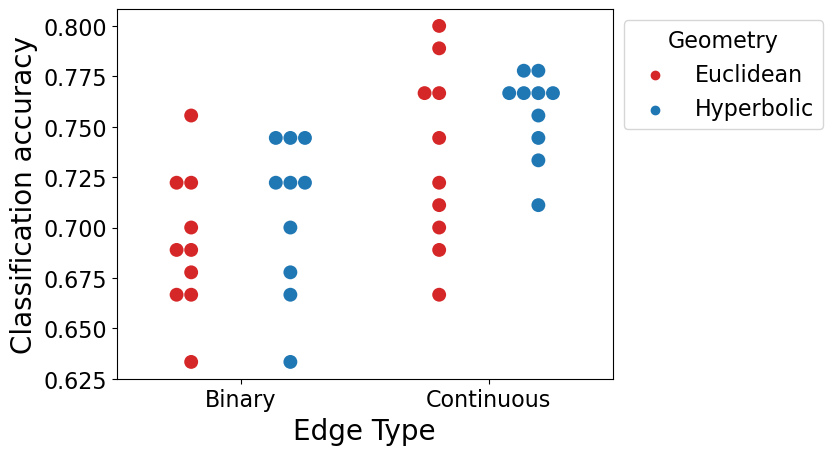

In [37]:
ax = sns.swarmplot(y='correct', 
              x='edge_type', 
              hue='geometry',
              data=df,
              s=10,
              palette=colors[:-1],
              dodge=True)
plt.ylabel('Classification accuracy', fontsize=label_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.xlabel('Edge Type', fontsize=label_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.legend(fontsize=tick_fontsize, bbox_to_anchor=(1.0,1.0)).set_title(title='Geometry', prop={'size':tick_fontsize})
savename = os.path.join(folder, f'classification_accuracy{one_rest_txt}.png')
# plt.savefig(savename, bbox_inches='tight')
plt.show()

### For only  binary models

In [38]:
df_bin = df[df['edge_type']=='Binary']

C:\Users\Pleun\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  import sys


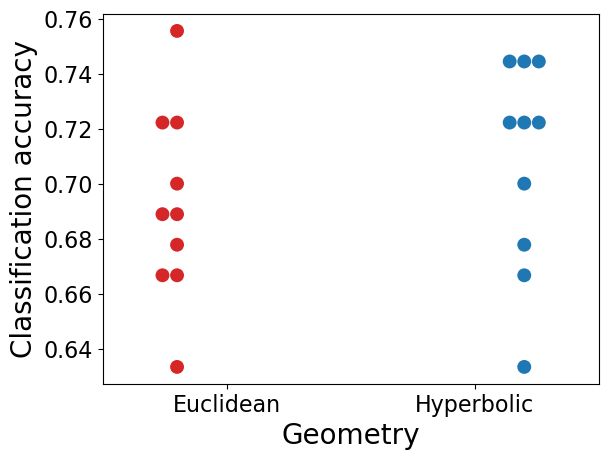

In [39]:
sns.swarmplot(y='correct', 
              x='geometry', 
              hue='geometry',
              data=df_bin,
              s=10,
              palette=colors,
              dodge=True)
plt.xlabel('Geometry', fontsize=label_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.ylabel('Classification accuracy', fontsize=label_fontsize)
plt.yticks(fontsize=tick_fontsize)
ax = plt.gca()
ax.get_legend().remove()
savename = os.path.join(folder, f'classification_accuracy{one_rest_txt}.png')
plt.savefig(savename, bbox_inches='tight')
plt.show()

### ANOVA  on the accuracies

In [40]:
model = ols('logit_correct ~ C(model)', data=comb_df).fit()
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(model),1.0,9.789262,9.789262,184.343691,4.674371e-18
Residual,48.0,2.548959,0.053103,NaN,NaN


In [41]:
model = ols('logit_correct ~ C(geometry)', data=df_bin).fit()
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(geometry),1.0,0.028248,0.028248,0.949243,0.342825
Residual,18.0,0.535647,0.029758,NaN,NaN


In [42]:
model = ols('logit_correct ~ C(edge_type) + C(geometry) + C(edge_type):C(geometry)', data=df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(edge_type),0.543060,1.0,17.204315,0.000195
C(geometry),0.079297,1.0,2.512142,0.121719
C(edge_type):C(geometry),0.001928,1.0,0.061079,0.806202
Residual,1.136352,36.0,NaN,NaN


In [43]:
model = ols('arcsinsqrt_correct ~ C(edge_type) + C(geometry) + C(edge_type):C(geometry)', data=df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(edge_type),0.026822,1.0,16.980132,0.000212
C(geometry),0.004083,1.0,2.584582,0.116645
C(edge_type):C(geometry),0.000097,1.0,0.061256,0.805927
Residual,0.056866,36.0,NaN,NaN
